## An attempt to break captcha using naive network

In [27]:
from captcha.image import ImageCaptcha
import matplotlib 
matplotlib.use('Agg') 
from matplotlib import pyplot as plt
import numpy as np
import random
import keras
import tensorflow as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from keras.utils import multi_gpu_model
%matplotlib inline

In [28]:
%config InlineBackend.figure_format = 'retina'

import string
# What all to include in the captcha
characters = string.digits + string.ascii_uppercase
print(characters)

#width and height of the captcha
# number of characters in captcha and number of classes captcha can take characters from
width, height, n_len, n_class = 170, 80, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# Data Generator

In [29]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
#             print("randome_str:", random_str)
            X[i] = generator.generate_image(random_str)
            # Range of j is 4
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

# Test Generator

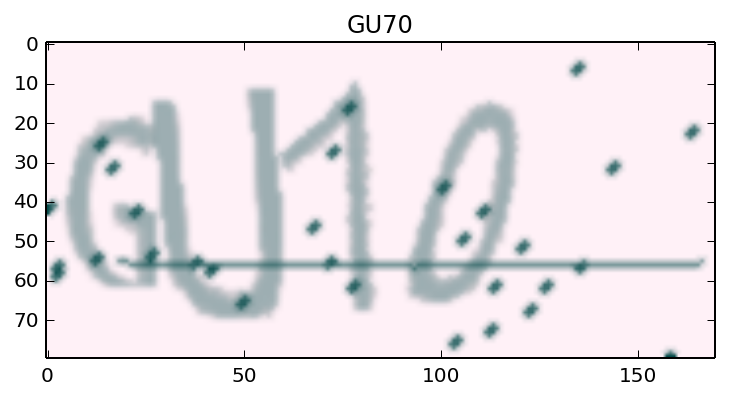

In [30]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# Network structure

In [35]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(32*2**i,(3, 3), activation='relu')(x)
    x = Conv2D(32*2**i,(3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)
# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
model = multi_gpu_model(model, gpus=4)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

/local/usr.local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


# Network structure visualization

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 80, 170, 3)   0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, 80, 170, 3)   0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, 80, 170, 3)   0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_20 

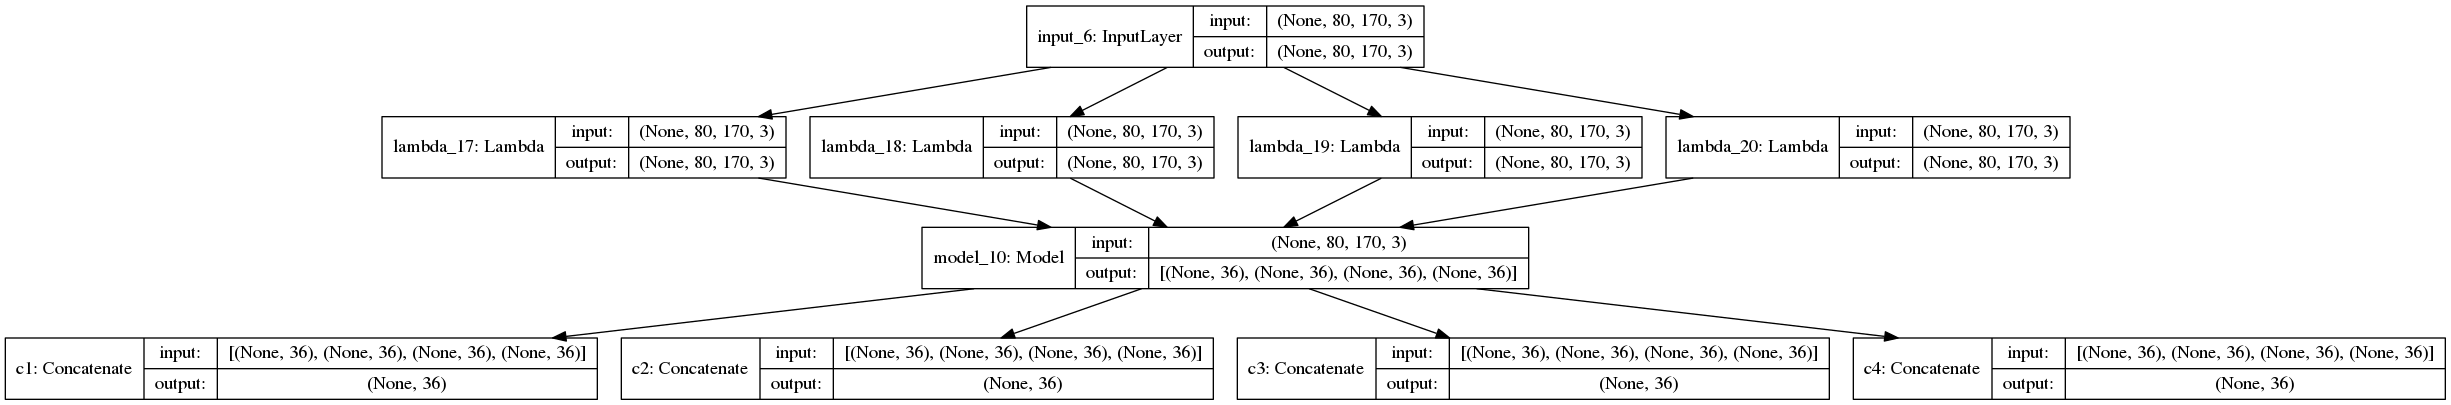

In [36]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
model.summary()

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# Training

In [ ]:
model.fit_generator(gen(64), samples_per_epoch=25600, nb_epoch=3,
                    validation_data=gen(), nb_val_samples=1280)

Epoch 1/3
 5235/25600 [=====>........................] - ETA: 1:18:48 - loss: 14.3349 - c1_loss: 3.5838 - c2_loss: 3.5837 - c3_loss: 3.5837 - c4_loss: 3.5837 - c1_acc: 0.0279 - c2_acc: 0.0276 - c3_acc: 0.0281 - c4_acc: 0.0280

# Test Model

(-0.5, 169.5, 79.5, -0.5)

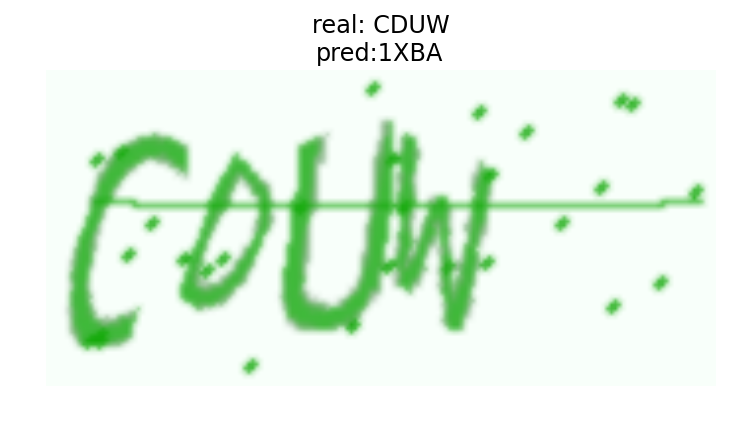

In [18]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# Calculate the overall model accuracy

In [19]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


0.0

# Save model

In [17]:
model.save('cnn.h5')